<a href="https://colab.research.google.com/github/ravenlanghorne/water_storage/blob/main/Clear_Creek_Fire_Storage_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Research Question: How do changes in vegetation impact catchment storage in Clear Creek?**

To answer this question I will use the python code for Dralle et al. 2018 in [this](https://github.com/daviddralle/indirect_storage) github repository. 

*Event:*
2018 [Carr Fire](https://en.wikipedia.org/wiki/Carr_Fire)

*Catchment:*
Clear Creek [11372000](https://waterdata.usgs.gov/monitoring-location/11372000/#parameterCode=00060)


# Data Pulling

In [ ]:
!pip install geopandas 

     |████████████████████████████████| 1.0MB 4.9MB/s 
     |████████████████████████████████| 6.5MB 15.6MB/s 
     |████████████████████████████████| 15.3MB 244kB/s 
     |████████████████████████████████| 92kB 5.7MB/s 
  Found existing installation: click 8.0.0
    Uninstalling click-8.0.0:
      Successfully uninstalled click-8.0.0


In [ ]:
import geopandas as gp
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys
import seaborn as sns
from scipy.optimize import curve_fit
import glob
import pickle
import scipy
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
import datetime
from sklearn.metrics import r2_score
import datetime
from google.colab import files


In [ ]:
# Import the Earth Engine API and initialize it.
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=rrgl7ROb709oPFDYWeJCu9Wr4CnUTRrCVVGf8bYhUX8&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g4Psl8XYfIL6Ql6Yguhmc1gxs9VkOyQnE3A67lmMu9XOrQg9CUYos0

Successfully saved authorization token.


In [ ]:
#helper functions

# Rainfall interception function
def intercept_rain(ppt, interception_depth):
    freq = ppt.index.freq
    idx = ppt.index.copy()
    prcp = ppt.copy()
    precip_pre = ppt.ppt.resample('D').mean()+1e-12
    precip_post = precip_pre.apply(lambda x: np.max([0,x-interception_depth])) 
    frac_int = (precip_pre.sum() - precip_post.sum())/precip_pre.sum()
    print('Fraction intercepted = %.2f'%frac_int)
    rng = pd.date_range(precip_post.index[0], precip_post.index[-1], freq=freq)
    daily_multiplication_factor = precip_post/precip_pre
    daily_multiplication_factor = pd.DataFrame({'factor':daily_multiplication_factor.resample(freq).ffill().tolist()},index=rng)
    ppt.ppt = daily_multiplication_factor.factor*prcp.ppt
    return ppt

# Sensitivity function [see Kirchner, 2009] doi:10.1029/2008WR006912
def g(q,p):
    if np.size(np.array(q)) == 1: return np.exp(np.sum([p[i]*np.log(q)**(len(p)-i-1) for i in range(len(p))]))
    return [np.exp(np.sum([p[i]*np.log(qq)**(len(p)-i-1) for i in range(len(p))])) for qq in np.array(q)]

# Bin dq/dt data
def KirchnerBinning(df, min_per_bin = 10, loud=False):
    df = df.sort_values('q',ascending=False)
    
    logQ = np.array(np.log(df.q))
    
    logRange = np.max(logQ) - np.min(logQ)
    minBinSize = logRange*.01
  
    binBoundaries = [0]
    for i in range(1,len(df)):    
        if abs(logQ[i] - logQ[binBoundaries[-1]]) < minBinSize: 
            if loud: print('Bin too small')
            continue
            
        if abs(i-binBoundaries[-1]) < min_per_bin:
            if loud: print('Not enough data points')
            continue  
            
        curr = df.dq[binBoundaries[-1]:i]
        if np.std(-curr)/np.sqrt(abs(i-binBoundaries[-1])) > np.mean(-curr)/2: 
            if loud: print('Bin too heterogeneous')
            continue    
        
        binBoundaries.append(i)
    return binBoundaries

### Loading in USGS Data

In [ ]:
#Part 1
#load in flow data
#first we need to define the station number and the time interval we want to search
site = '11372000' 
startyear=1988
start = '1988-09-30'
stopyear=2021 #you want to go one over the year you intend to stop at
stop = '2020-12-04'

#then we can construct the url 
url = 'https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=' + site + '&referred_module=sw&period=&begin_date='+start+'&end_date='+stop

print(url)

https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=11372000&referred_module=sw&period=&begin_date=1988-09-30&end_date=2020-12-04


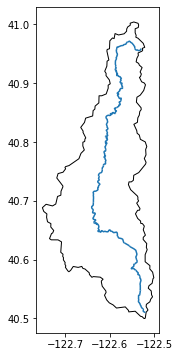

In [ ]:
#get the basin upstream of the site
basin = gp.read_file('https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-'+site+'/basin')

#get all upstream with tributaries flowlines
UT_flow=gp.read_file("https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-"+site+"/navigation/UT/flowlines?distance=999")

#get the upstream mainstem flowlines
UM_flow=gp.read_file("https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-"+site+"/navigation/UM/flowlines?distance=999")

#get the downstream mainstem flowlines
DM_flow = gp.read_file("https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-"+site+"/navigation/DM/flowlines?distance=999")


#plot
f,ax = plt.subplots(1,figsize=(6,6))
basin.plot(ec='k',fc='w',ax=ax)
UM_flow.plot(ax=ax)

In [ ]:
site_lat=basin.to_crs('epsg:4326').geometry[0].centroid.y
site_lon=basin.to_crs('epsg:4326').geometry[0].centroid.x

drainage_area=basin.to_crs('epsg:26910').geometry.area #how do you know original drainage area was in m2?
print(drainage_area.values,'drainage area in m2')
drainage_area_km2=drainage_area/(1000*1000)
print(drainage_area_km2.values,'drainage area in km2')
drainage_area_mm2=drainage_area*(1000*1000)
print(drainage_area_mm2.values,'drainage area in mm2')

[5.91536712e+08] drainage area in m2
[591.53671231] drainage area in km2
[5.91536712e+14] drainage area in mm2


In [ ]:
#Part 1 - Load in flow data 
#creating a flow (df) data frame

#we can read the csv by simply using the pd.read_csv command.  In this case, we need to ignore the first 31 lines of the csv because it is part of the header. 
df = pd.read_csv(url, header=31, delim_whitespace=True)

# we can name each of the columns in the dataset with our own names by using the command df.columns. note that you must have the same number of entries here as you do columns in your dataframe. 
df.columns = ['usgs', 'site_number', 'datetime', 'q', 'a'] #'b','c','d','e']

#we need to convert the dates to a datetime format that python understands
df['Date'] = pd.to_datetime(df.datetime)

#finally, we can create a clean dataframe and name the columns with names we understand
df = df[['q','Date']]

df['q_cfs'] = df['q']
df['q'] = df['q'].astype(float, errors='ignore')  #this is needed because sometimes there are non-numeric entries and we want to ignore them


#converting to runoff
df['q_mday']= (86400*df['q'])/(35.31*(drainage_area.values)) #m/day

df['q_mmday']= (86400*df['q'])/((3.5e-8)*(drainage_area_mm2.values)) #mm/day

df['q']=df['q_mday'] #we want final results in m/day

df.set_index('Date',inplace=True) #pandas dataframes have an index column- for timeseries, we usually assign the datetime as the index 

df.head()

,q,q_cfs,q_mday,q_mmday
Date,,,,
1988-10-02,0.000228,55.0,0.000228,0.229523
1988-10-03,0.000228,55.0,0.000228,0.229523
1988-10-04,0.000228,55.0,0.000228,0.229523
1988-10-05,0.000228,55.0,0.000228,0.229523
1988-10-06,0.000228,55.0,0.000228,0.229523


In [ ]:
df['q'].mean()

0.0009296321249875536

### Loading in Prism Data

In [ ]:
#pulling coords
coords = [item for item in basin.geometry[0].exterior.coords]
gee_feat = ee.Feature(ee.Geometry.Polygon(coords))
gee_feat = gee_feat.set('Site',1)
fts_list = [gee_feat]
fts = ee.FeatureCollection(fts_list)

Daily Prism

In [ ]:
#fts = ee.FeatureCollection(fts_list[0:2])

def extract(image):
        val = image.reduceRegions(fts, ee.Reducer.mean())
        return val

def get_prism(minyear, maxyear, variable):
    dfs = []
    for year in range(minyear, maxyear):
      print('Getting year %s'%str(year))
      for month in range(1,13):
        start = (
          pd.to_datetime(str(year) + '-' + str(month)) - pd.to_timedelta(1,unit='D')
        ).strftime('%Y-%m-%d')
        if month==12:
          stop = (
            pd.to_datetime(str(year+1) + '-' + str(1)) - pd.to_timedelta(1,unit='D')
          ).strftime('%Y-%m-%d')
        else:
          stop = (
            pd.to_datetime(str(year) + '-' + str(month+1)) - pd.to_timedelta(1,unit='D')
          ).strftime('%Y-%m-%d')

        prism = ee.ImageCollection('OREGONSTATE/PRISM/AN81d').select(variable).filterDate(start, stop)
        extracted = prism.map(extract).flatten().getInfo()
        sites = []
        vals = []
        dates = []
        for feat in extracted['features']:
            site = feat['properties']['Site']
            try:
                val = feat['properties']['mean']
            except:
                val = np.nan
            date = pd.to_datetime(feat['id'].split('_')[0])
            sites.append(site), vals.append(val), dates.append(date)     
        df = pd.DataFrame(vals, index=dates, columns=[variable])
        df['site'] = sites
        df = df.pivot(columns='site')
        dfs.append(df)
    prism = pd.concat(dfs)
    return prism[variable]



In [ ]:
stopyear

2021

In [ ]:
#pulling variables

variable = 'ppt'
ppt_prism = get_prism(startyear, stopyear, variable)

variable = 'tmean'
tmean = get_prism(startyear, stopyear, variable)

variable = 'tmax'
tmax = get_prism(startyear, stopyear, variable)

variable = 'tmin'
tmin = get_prism(startyear, stopyear, variable)
ppt_prism.tail()

Getting year 1988
Getting year 1989
Getting year 1990
Getting year 1991
Getting year 1992
Getting year 1993
Getting year 1994
Getting year 1995
Getting year 1996
Getting year 1997
Getting year 1998
Getting year 1999
Getting year 2000
Getting year 2001
Getting year 2002
Getting year 2003
Getting year 2004
Getting year 2005
Getting year 2006
Getting year 2007
Getting year 2008
Getting year 2009
Getting year 2010
Getting year 2011
Getting year 2012
Getting year 2013
Getting year 2014
Getting year 2015
Getting year 2016
Getting year 2017
Getting year 2018
Getting year 2019
Getting year 2020
Getting year 1988
Getting year 1989
Getting year 1990
Getting year 1991
Getting year 1992
Getting year 1993
Getting year 1994
Getting year 1995
Getting year 1996
Getting year 1997
Getting year 1998
Getting year 1999
Getting year 2000
Getting year 2001
Getting year 2002
Getting year 2003
Getting year 2004
Getting year 2005
Getting year 2006
Getting year 2007
Getting year 2008
Getting year 2009
Getting ye

site,1
2020-12-21,0.000000
2020-12-22,0.444881
2020-12-23,0.000000
2020-12-24,0.000000
2020-12-25,0.000000


In [ ]:
ppt_prism.columns = ['ppt'] #in mm/day

ppt_prism.index

DatetimeIndex(['1988-01-01', '1988-01-02', '1988-01-03', '1988-01-04',
               '1988-01-05', '1988-01-06', '1988-01-07', '1988-01-08',
               '1988-01-09', '1988-01-10',
               ...
               '2020-12-16', '2020-12-17', '2020-12-18', '2020-12-19',
               '2020-12-20', '2020-12-21', '2020-12-22', '2020-12-23',
               '2020-12-24', '2020-12-25'],
              dtype='datetime64[ns]', length=12048, freq=None)

### Calculating Daily PET

Hargreave and Samani 1985: Equation:

Ep = 0.0023 · (Tmean + 17.8)·(Tmax − Tmin)^0.5 · 0.408 · Rext

Rext = Exterrestrial radiation [MJ m-2 day-1] (Allen et al 1998)

Equation:
Ra = 1440/pi(Gsc)(dr)[ws*sin(ϕ)*sin(δ)+cos(ϕ)*cos(δ)*sin(ws)]

In [ ]:
site_lat

40.72287430486206

In [ ]:
#Ra =  Extraterrestrial solar radiation 

#making a dataframe to store all the variables
Rext = pd.DataFrame(columns = ['J','dr','d','ws','Ra'])

#latitudes: 40°30'48 in degrees and minutes
dec_deg = site_lat

#j (ϕ) in radians
j = (np.pi/180)*(dec_deg)

Gsc = 0.0820 #MJ m-2 day -1

#julian days
Rext.J = np.linspace(1,365,365) 

#inverse relative distance Earth-Sun, dr
Rext.dr = 1+0.033*np.cos(((2*np.pi)/365)*Rext.J)

#solar declination δ (aka d)
Rext.d = 0.409*np.sin(((2*np.pi)/365)*Rext.J-1.39)

#sunset hour angle
Rext.ws = np.arccos(-np.tan(j)*np.tan(Rext.d))

Rext.Ra = (1440/np.pi)*(Gsc*Rext.dr)*(Rext.ws*np.sin(j)*np.sin(Rext.d)+np.cos(j)*np.cos(Rext.d)*np.sin(Rext.ws))

Rext


,J,dr,d,ws,Ra
0,1.0,1.032995,-0.401008,1.197189,13.384862
1,2.0,1.032980,-0.399564,1.198763,13.440460
2,3.0,1.032956,-0.398001,1.200463,13.500540
3,4.0,1.032922,-0.396320,1.202287,13.565092
4,5.0,1.032878,-0.394522,1.204235,13.634103
...,...,...,...,...,...
360,361.0,1.032922,-0.406440,1.191242,13.174424
361,362.0,1.032956,-0.405594,1.192172,13.207480
362,363.0,1.032980,-0.404627,1.193232,13.245058
363,364.0,1.032995,-0.403540,1.194422,13.287153


In [ ]:
tmin.columns = ['tmin']
tmax.columns = ['tmax']
tmean.columns = ['tmean']
pet_prism = tmin.merge(tmax, how = 'outer', left_index=True, right_index=True)
pet_prism  = pet_prism.merge(tmean, how = 'outer', left_index=True, right_index=True)
pet_prism 

,tmin,tmax,tmean
1988-01-01,-5.097724,5.084715,-0.006391
1988-01-02,-3.786037,5.803752,1.008454
1988-01-03,-0.752765,4.492470,1.869349
1988-01-04,0.326357,4.290282,2.307908
1988-01-05,0.100827,5.621068,2.860459
...,...,...,...
2020-12-21,4.660036,13.405093,9.032517
2020-12-22,1.860324,12.128595,6.994401
2020-12-23,0.721330,8.345927,4.533585
2020-12-24,1.338046,11.025198,6.181565


In [ ]:
#calculating pet using Hargreaves equation
#used 13.5 means Ra for the year
pet_prism ['pet']= 0.0023 *(pet_prism.tmean + 17.8)*(pet_prism.tmax - pet_prism.tmin)**0.5 * 0.408 * 13.5
pet_prism  #in mm/day

,tmin,tmax,tmean,pet
1988-01-01,-5.097724,5.084715,-0.006391,0.719303
1988-01-02,-3.786037,5.803752,1.008454,0.737869
1988-01-03,-0.752765,4.492470,1.869349,0.570682
1988-01-04,0.326357,4.290282,2.307908,0.507167
1988-01-05,0.100827,5.621068,2.860459,0.614951
...,...,...,...,...
2020-12-21,4.660036,13.405093,9.032517,1.005228
2020-12-22,1.860324,12.128595,6.994401,1.006524
2020-12-23,0.721330,8.345927,4.533585,0.781248
2020-12-24,1.338046,11.025198,6.181565,0.945578


In [ ]:
ppt_prism.index
pet_prism.index
df.index

DatetimeIndex(['1988-10-01', '1988-10-02', '1988-10-03', '1988-10-04',
               '1988-10-05', '1988-10-06', '1988-10-07', '1988-10-08',
               '1988-10-09', '1988-10-10',
               ...
               '2020-11-25', '2020-11-26', '2020-11-27', '2020-11-28',
               '2020-11-29', '2020-11-30', '2020-12-01', '2020-12-02',
               '2020-12-03', '2020-12-04'],
              dtype='datetime64[ns]', name='Date', length=11753, freq=None)

### Converting units

In [ ]:
#converting units to m/day original units in mm/day

ppt=ppt_prism/1000 #in m/day

pet=pet_prism/1000 #in m/day

In [ ]:
#creating copy dataframe for reference dataframe
ppt2=ppt.copy()
pet2=pet.copy()


### Downloading Data

In [ ]:
#ppt.to_csv('./CCppt.csv')
#files.download('./CCppt.csv')

#df.to_csv('./CCq.csv')
#files.download('./CCq.csv')


#pet.to_csv('./CCpet.csv')
#files.download('./CCpet.csv')

In [ ]:
# Reload rainfall and PET
# Load rainfall and flow data
# ppt = pd.read_csv('/content/eppt.csv')
# df = pd.read_csv('/content/eq.csv')
# pet = pd.read_csv('/content/epet.csv')


# #cleaning up dataframes
# pet.columns=['Datetime', 'tmin', 'tmax', 'tmean', 'pet']
# ppt.columns=['Datetime', 'ppt']
# df.columns=['Datetime', 'q']
# df.set_index('Datetime',inplace=True)
# ppt.set_index('Datetime',inplace=True)
# pet.set_index('Datetime',inplace=True)

#Conducting Analysis

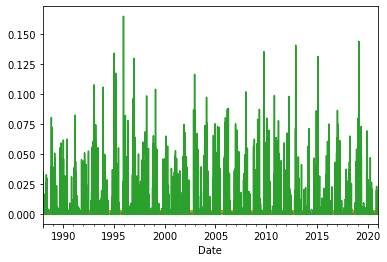

In [ ]:
df.q.plot()
pet.pet.plot()
ppt.ppt.plot()

In [ ]:
#recession analysis

# Lag in days after neglible rainfall before analysis starts
rainfall_lag = 1.0
mean_fraction = 0.001

# Keep tabs on rainfall total of previous rainfall_lag days
rainfall_lag *= (24*60*60.)

# Resample to daily for this analysis
freq = '1D'
ppt = ppt.resample(freq).mean()
df = df.resample(freq).mean()
x = df.index.freq
num_secs = x.delta.days*(60*60*24) + x.delta.seconds
dt = num_secs/(24.*60*60)
lag = int(rainfall_lag/num_secs)
meanQ = np.mean(df.q)

# Lists to store q and its derivative
dqs = []
qs = []
years = list(set(ppt.index.year))
years.sort()
for year in years:
  
        
    # Only use winter month recessions
    startdate = '11-' + str(year)
    enddate = '3-' + str(year+1)
    rain = np.array(ppt.ppt.loc[startdate:enddate])
    runoff = np.array(df.q.loc[startdate:enddate])
    i = lag
    while i<len(rain):
        # Too much rain
        if np.sum(dt*rain[i-lag:i+1]) > .002:
            i+=1
            continue

        # We have found period of negligible rainfall 
        # Find index of next day of rainfall 
        idx_next_rain = np.where(rain[i+1:]>0)[0]
        if len(idx_next_rain)>0:
            idx_next_rain = idx_next_rain[0] + (i+1)
        else: 
            # no more rain for this particular year
            break
        
        # too short of a rainless period for analysis 
        if idx_next_rain==i+1: 
            i += 2
            continue
        
        # get dq/dt going forward, not including the next day of rainfall
        for j in range(i, idx_next_rain):
            q_diffs = runoff[j] - runoff[j+1:idx_next_rain]
            idx_end = np.where(q_diffs>mean_fraction*meanQ)[0]
            if len(idx_end)>0:
                idx_end = idx_end[0]
                qs.append((runoff[j] + runoff[j+idx_end+1])/2)
                dqs.append((runoff[j+idx_end+1]-runoff[j])/(dt*(idx_end+1)))
            else:
                i = idx_next_rain + lag + 1
                break 
        i = idx_next_rain + lag + 1
   

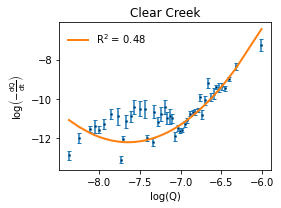

In [ ]:
qs = np.array(qs)
dqs = np.array(dqs)    
qs = np.array(qs)
dqs = np.array(dqs)
df_kirchner = pd.DataFrame({'q':qs, 'dq':dqs})
df_kirchner = df_kirchner.sort_values('q',ascending=False)
binBoundaries = KirchnerBinning(df_kirchner, min_per_bin=7)
qs = [np.mean(df_kirchner.q[binBoundaries[i]:binBoundaries[i+1]]) for i in range(len(binBoundaries)-1)]
dqs =   np.array([np.mean(df_kirchner.dq[binBoundaries[i]:binBoundaries[i+1]]) for i in range(len(binBoundaries)-1)])
sigmas = np.array([np.std(np.log(-df_kirchner.dq[binBoundaries[i]:binBoundaries[i+1]].loc[df_kirchner.dq[binBoundaries[i]:binBoundaries[i+1]]<0]))/np.sqrt(binBoundaries[i+1]-binBoundaries[i]) for i in range(len(binBoundaries)-1)]) + 1e-12
p = np.polyfit(x=np.log(qs), y=np.log(-dqs), deg=2, w=1/sigmas**2)
f = plt.figure(figsize=(4,3))
plt.errorbar(np.log(qs), np.log(-dqs), yerr = sigmas,fmt='o',capsize=2,**{'ms':2, 'mfc':'k','zorder':1})
x = np.log(qs)
coefficient_of_dermination = r2_score(np.log(-dqs), p[2] + p[1]*x + p[0]*x**2)
plt.plot(x, p[2] + p[1]*x + p[0]*x**2,lw=2, label='$\mathrm{R^2}$ = %.2f'%coefficient_of_dermination,zorder=10)
p[1] = p[1]-1
plt.xlabel('log(Q)')
leg = plt.legend(fontsize=10,loc='best')
leg.set_frame_on(False)
#plt.ylim([-12,-5])
#plt.xlim([-9.1,-4])
plt.title('Clear Creek',fontsize=12)
ax = f.get_axes()[0]
plt.ylabel(r'$\log \left( -\mathrm{\frac{dQ}{dt}}\right)$')
plt.tight_layout()
# plt.savefig('./figures/dqdt_vs_q_clearcreek.pdf')

In [ ]:
ppt = ppt2.resample(freq).mean()
pet = pet.resample(freq).mean()

# simple interception model; 4mm/day at Clear Creek
interception_depth = 0.004
ppt = intercept_rain(ppt, interception_depth)

Fraction intercepted = 0.22


In [ ]:
# Now use sensitivity function to compute direct storage time series for each year
years = list(set(df.index.year))
years.sort()
df['direct_storage'] = 0 
for year in years: 
    startDate = '10-01-' + str(year)
    endDate = '9-30-' + str(year+1)
    thisYear = df.loc[startDate:endDate]
    if len(thisYear)<100:
        continue
    # cumulative integral of dynamic storage for this water year, assuming we start at 0        
    qvar = thisYear.q.tolist()
    direct_S = [0]
    for i in range(1,len(qvar)):
        qi = qvar[i]
        qi1 = qvar[i-1]
        qintegrate = np.linspace(qi1, qi, 5)
        direct_S.append(direct_S[i-1] + np.trapz([1/gg for gg in g(qintegrate,p)],qintegrate))
        if direct_S[i] < 0: 
            direct_S[i] = 0
    df['direct_storage'].loc[startDate:endDate] = direct_S

In [ ]:
df['indirect_storage'] = 0
df['total'] = 0
annualmax_indirect = []
annualmax_direct = []
maxyears = []
for year in years[:-1]: 
    startDate = '10-1-' + str(year)
    endDate = '6-1-' + str(year+1)
    idx = ppt.ppt.loc[startDate:endDate].index
    thisYear = df.loc[idx]
    petYear = pet.pet.loc[idx].values
    direct_year = df['direct_storage'].loc[idx].values
    cumQ = np.array(dt*thisYear.q.cumsum())
    rain = np.array(ppt.ppt.loc[idx].ffill())
    cumRain = np.array(dt*ppt.ppt.loc[idx].ffill().cumsum())
    indirect_year = np.zeros(np.shape(cumRain))
    
    for i in range(1,len(indirect_year)):
        iyt = cumRain[i] - cumQ[i] - np.cumsum(petYear*dt)[i] - direct_year[i]
        if iyt<0:
            petYear[i] = 0
        indirect_year[i] = cumRain[i] - cumQ[i] - np.cumsum(petYear*dt)[i] - direct_year[i]
    total = cumRain - cumQ - np.cumsum(petYear)*dt
    indirect_year_df = pd.DataFrame(indirect_year, index=idx).resample('D').mean()
    direct_year_df = pd.DataFrame(direct_year, index=idx).resample('D').mean()
    maxyears.append(year+1)
    df['indirect_storage'].loc[idx] = indirect_year
    df['total'].loc[idx] = total
    annualmax_indirect.append(np.max(indirect_year))
    annualmax_direct.append(np.max(direct_year))

df = df*1000.0 #in mm
annualmax_indirect = 1000*np.array(annualmax_indirect)
annualmax_direct = 1000*np.array(annualmax_direct)

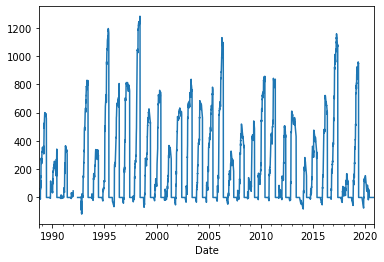

In [ ]:
df['indirect_storage'].plot()

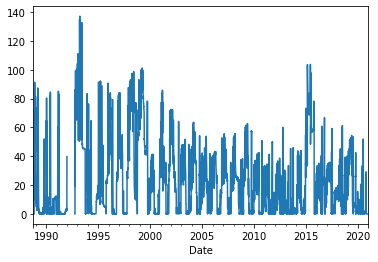

In [ ]:
df['direct_storage'].plot()

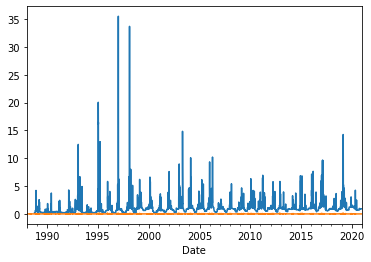

In [ ]:
df['q'].plot()
ppt['ppt'].plot()
pet['pet'].plot

# Making Graphs

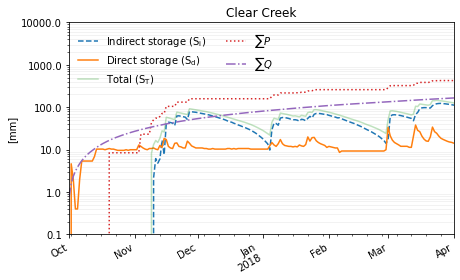

In [ ]:
start_date = '10-2017'
end_date = '4-2018'
uselog = True
f, (ax1) = plt.subplots(1,figsize=(6.5,4))
labels = []
df.indirect_storage.plot(style='--',linewidth=1.5, ax=ax1)
labels.append('Indirect storage ($\mathrm{S}_\mathrm{i}$)')
df.direct_storage.plot(linewidth=1.5, ax=ax1)
labels.append('Direct storage ($\mathrm{S}_\mathrm{d}$)')
df.total.plot(linewidth=1.5, ax=ax1, alpha=0.3)
labels.append('Total ($\mathrm{S}_\mathrm{T}$)')

pcumulative = ppt.ppt.loc[start_date:end_date].cumsum()*dt*1000
qcumulative = df.q.loc[start_date:end_date].cumsum()*dt
pcumulative.plot(style=':', lw=1.5)
labels.append('$\sum P$')
qcumulative.plot(style='-.', lw=1.5)
labels.append('$\sum Q$')

ax1.set_xlim([start_date,end_date])
if uselog:
    ax1.set_yscale('log')
    ax1.set_ylim([1e-1,1e4])
    ax1.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.1f"))
    ax1.yaxis.grid(which="minor", color='k', linestyle='-', linewidth=0.5, alpha=0.1)
else:
    ax1.set_ylim([0,2000])
    ax1.grid(**{'ls':'--', 'lw':0.3})


ax1.set_title('Clear Creek')

leg = ax1.legend(labels, loc='upper left', ncol=2)
leg.set_frame_on(False)
ax1.set_ylabel('[mm]')
ax1.set_xlabel('')
f.autofmt_xdate()
plt.tight_layout()
#plt.savefig('./figures/clearcreek' + start_date + '_' + end_date + '.pdf')

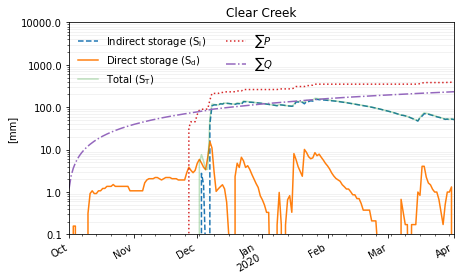

In [ ]:
start_date = '10-2019'
end_date = '4-2020'
uselog = True
f, (ax1) = plt.subplots(1,figsize=(6.5,4))
labels = []
df.indirect_storage.plot(style='--',linewidth=1.5, ax=ax1)
labels.append('Indirect storage ($\mathrm{S}_\mathrm{i}$)')
df.direct_storage.plot(linewidth=1.5, ax=ax1)
labels.append('Direct storage ($\mathrm{S}_\mathrm{d}$)')
df.total.plot(linewidth=1.5, ax=ax1, alpha=0.3)
labels.append('Total ($\mathrm{S}_\mathrm{T}$)')

pcumulative = ppt.ppt.loc[start_date:end_date].cumsum()*dt*1000
qcumulative = df.q.loc[start_date:end_date].cumsum()*dt
pcumulative.plot(style=':', lw=1.5)
labels.append('$\sum P$')
qcumulative.plot(style='-.', lw=1.5)
labels.append('$\sum Q$')

ax1.set_xlim([start_date,end_date])
if uselog:
    ax1.set_yscale('log')
    ax1.set_ylim([1e-1,1e4]) 
    ax1.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.1f"))
    ax1.yaxis.grid(which="minor", color='k', linestyle='-', linewidth=0.5, alpha=0.1)
else:
    ax1.set_ylim([0,2000])
    ax1.grid(**{'ls':'--', 'lw':0.3})


ax1.set_title('Clear Creek')

leg = ax1.legend(labels, loc='upper left', ncol=2)
leg.set_frame_on(False)
ax1.set_ylabel('[mm]')
ax1.set_xlabel('')
f.autofmt_xdate()
plt.tight_layout()
#plt.savefig('./figures/clearcreek_' + start_date + '_' + end_date + '.pdf')

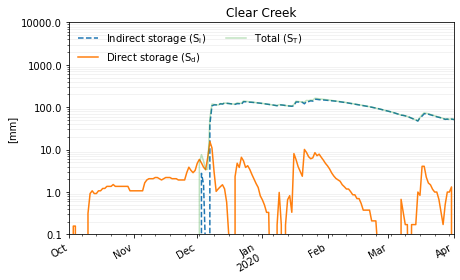

In [ ]:
#graphing storage only
start_date = '10-2019'
end_date = '4-2020'
uselog = True
f, (ax1) = plt.subplots(1,figsize=(6.5,4))
labels = []
df.indirect_storage.plot(style='--',linewidth=1.5, ax=ax1)
labels.append('Indirect storage ($\mathrm{S}_\mathrm{i}$)')
df.direct_storage.plot(linewidth=1.5, ax=ax1)
labels.append('Direct storage ($\mathrm{S}_\mathrm{d}$)')
df.total.plot(linewidth=1.5, ax=ax1, alpha=0.3)
labels.append('Total ($\mathrm{S}_\mathrm{T}$)')

ax1.set_xlim([start_date,end_date])
if uselog:
    ax1.set_yscale('log')
    ax1.set_ylim([1e-1,1e4])
    ax1.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.1f"))
    ax1.yaxis.grid(which="minor", color='k', linestyle='-', linewidth=0.5, alpha=0.1)
else:
    ax1.set_ylim([0,2000])
    ax1.grid(**{'ls':'--', 'lw':0.3})


ax1.set_title('Clear Creek')

leg = ax1.legend(labels, loc='upper left', ncol=2)
leg.set_frame_on(False)
ax1.set_ylabel('[mm]')
ax1.set_xlabel('')
f.autofmt_xdate()
plt.tight_layout()
#plt.savefig('./figures/clearcreek_' + start_date + '_' + end_date + '.pdf')


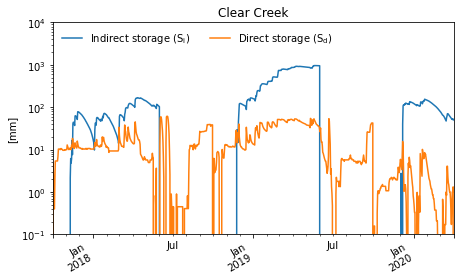

In [ ]:
#parsing out other factors
start_date = '10-2017'
end_date = '4-2020'
uselog = True
f, (ax1) = plt.subplots(1,figsize=(6.5,4))
labels = []
df.indirect_storage.plot(ax=ax1)
labels.append('Indirect storage ($\mathrm{S}_\mathrm{i}$)')
df.direct_storage.plot(linewidth=1.5, ax=ax1)
labels.append('Direct storage ($\mathrm{S}_\mathrm{d}$)')
#df.total.plot(linewidth=1.5, ax=ax1, alpha=0.3)
#labels.append('Total ($\mathrm{S}_\mathrm{T}$)')

#pcumulative = ppt.ppt.loc[start_date:end_date].cumsum()*dt*1000
#qcumulative = df.q.loc[start_date:end_date].cumsum()*dt
#pcumulative.plot(style=':', lw=1.5)
#labels.append('$\sum P$')
#qcumulative.plot(style='-.', lw=1.5)
#labels.append('$\sum Q$')

ax1.set_xlim([start_date,end_date])
if uselog:
    ax1.set_yscale('log')
    ax1.set_ylim([1e-1,1e4]) 
    #ax1.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.1f"))
    #ax1.yaxis.grid(which="minor", color='k', linestyle='-', linewidth=0.5, alpha=0.1)
else:
    ax1.set_ylim([0,2000])
    ax1.grid(**{'ls':'--', 'lw':0.3})


ax1.set_title('Clear Creek')

leg = ax1.legend(labels, loc='upper left', ncol=2)
leg.set_frame_on(False)
ax1.set_ylabel('[mm]')
ax1.set_xlabel('')
f.autofmt_xdate()
plt.tight_layout()



*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


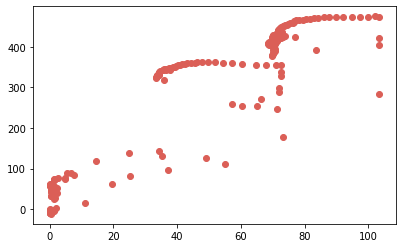

In [ ]:
import seaborn as sns
start_date = '10-2017'
end_date = '4-2018'
uselog = True
f, (ax1) = plt.subplots(1,figsize=(6.5,4))
labels = []
years = range(2014,2015)
pal = sns.color_palette("hls", len(years))

pcumulative = ppt.ppt.loc[start_date:end_date].cumsum()*dt*1000



for i,year in enumerate(years):
    start_date = '10-' + str(year)
    end_date = '4-' + str(year+1)
    instorage = df.loc[start_date:end_date].indirect_storage.values
    dstorage =  df.loc[start_date:end_date].direct_storage.values
    plt.scatter(dstorage, instorage,c=pal[i])


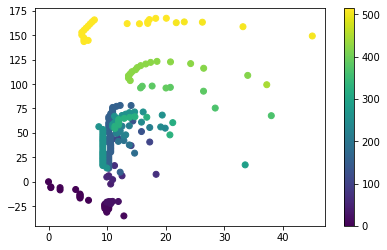

In [ ]:
import seaborn as sns
start_date = '10-2017'
end_date = '4-2018'
uselog = True
f, (ax1) = plt.subplots(1,figsize=(6.5,4))
labels = []
years = range(2014,2015)
pal = sns.color_palette("hls", len(years))

pcumulative = ppt.ppt.loc[start_date:end_date].cumsum()*dt*1000

instorage = df.loc[start_date:end_date].indirect_storage.values
dstorage =  df.loc[start_date:end_date].direct_storage.values
plt.scatter(dstorage, instorage,c=pcumulative.values)
plt.colorbar()

In [ ]:
idx = (df.index.month>=12)|(df.index.month<=2)
ismean = df.indirect_storage.loc[idx].mean()
isstd = np.std(df.indirect_storage.loc[idx])
iscv = isstd/ismean
dsmean = df.direct_storage.loc[idx].mean()
dsstd = np.std(df.direct_storage.loc[idx])
dscv = dsstd/dsmean
printstr = 'All winter months: indirect storage mean = %.2f pm %.2f, cv = %.2f; direct mean = %.2f, cv = %.2f'%(ismean, isstd, iscv, dsmean, dscv)
print(printstr)

All winter months: indirect storage mean = 289.18 pm 226.92, cv = 0.78; direct mean = 29.62, cv = 0.89


Text(0.5, 0, 'Water year')

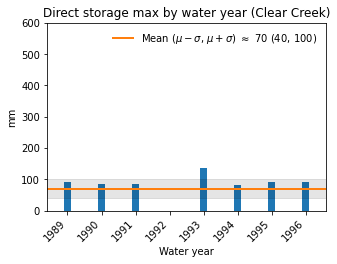

In [ ]:
d = pd.DataFrame({'Annual maximum':annualmax_direct[:-1], 'Year':maxyears[:-1]})
f = plt.figure(figsize=(5,4.5))
themean = 10*round(d['Annual maximum'].mean()/10.0)
upper = 10*round(np.std(d['Annual maximum'])/10.0)+themean
lower = -10*round(np.std(d['Annual maximum'])/10.0)+themean
legstr = r'Mean ($\mu - \sigma$, $\mu+\sigma$) $\approx$'
legstr +=  ' %.0f (%.0f, %.0f)'%(themean,lower,upper)
plt.plot([-2,12],[themean,themean],label=legstr,c='C1',lw=2)
h = plt.bar(range(len(d.Year)), d['Annual maximum'], width=0.2)
plt.subplots_adjust(bottom=0.3)
xticks_pos = [0.5*patch.get_width() + patch.get_xy()[0] for patch in h]
plt.xticks(xticks_pos, maxyears,  ha='right', rotation=45)

plt.ylabel('mm')
leg = plt.legend(loc='upper-left')
leg.set_frame_on(False)
plt.axhspan(lower,upper,color='k',alpha=0.1)

plt.xlim([-.6,7.6])
plt.ylim([0,600])
plt.title('Direct storage max by water year (Clear Creek)')
plt.xlabel('Water year')


Text(0.5, 0, 'Water year')

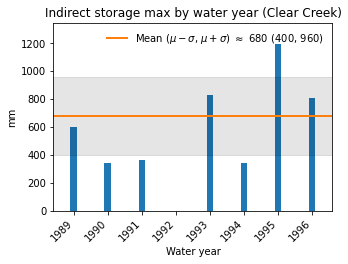

In [ ]:
d = pd.DataFrame({'Annual maximum':annualmax_indirect[:-1], 'Year':maxyears[:-1]})
f = plt.figure(figsize=(5,4.5))
themean = 10*round(d['Annual maximum'].mean()/10.0)
upper = 10*round(np.std(d['Annual maximum'])/10.0)+themean
lower = -10*round(np.std(d['Annual maximum'])/10.0)+themean
legstr = r'Mean ($\mu - \sigma$, $\mu+\sigma$) $\approx$'
legstr +=  ' %.0f (%.0f, %.0f)'%(themean,lower,upper)
plt.plot([-2,12],[themean,themean],label=legstr,c='C1',lw=2)
h = plt.bar(range(len(d.Year)), d['Annual maximum'], width=0.2)
plt.subplots_adjust(bottom=0.3)
xticks_pos = [0.5*patch.get_width() + patch.get_xy()[0] for patch in h]
plt.xticks(xticks_pos, maxyears,  ha='right', rotation=45)

plt.ylabel('mm')
leg = plt.legend(loc='upper-left')
leg.set_frame_on(False)
plt.axhspan(lower,upper,color='k',alpha=0.1)

plt.xlim([-.6,7.6])
#plt.ylim([0,600])
plt.title('Indirect storage max by water year (Clear Creek)')
plt.xlabel('Water year')

#plt.savefig('./figures/clearcreek.pdf')

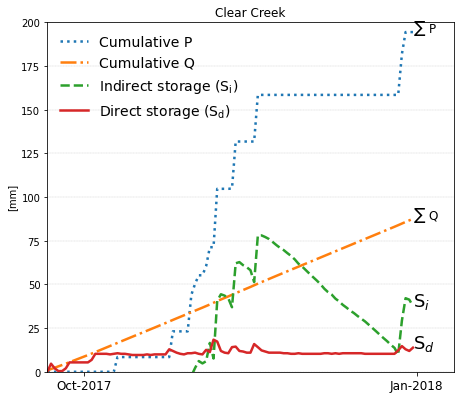

In [ ]:
fig, (ax) = plt.subplots(1,figsize=(6.5,6))
start_date = '10-2017'
end_date = '1-09-2018'
indirect = df.indirect_storage.loc[start_date:end_date].values
direct = df.direct_storage.loc[start_date:end_date].values
total = df.total.loc[start_date:end_date].values
prcp = ppt.ppt.loc[start_date:end_date].cumsum().values*dt*1000
dis = df.q.loc[start_date:end_date].cumsum().values*dt

idx = df.loc[start_date:end_date].index.to_pydatetime()

x0, y0i = idx[0], indirect[0]
y0d = direct[0]
y0t = total[0]
y0p = prcp[0]
y0q = dis[0]

lp, = ax.plot(x0, y0p,':', label='Cumulative P', lw=2.5)
lq, = ax.plot(x0, y0q,'-.', label='Cumulative Q', lw=2.5)
# lt, = ax.plot(x0, y0t, label='Total storage',c='k',linewidth=1., alpha=0.3)
li, = ax.plot(x0, y0i,'--', label='Indirect storage ($\mathrm{S_i}$)',linewidth=2.5)
ld, = ax.plot(x0, y0d, label='Direct storage ($\mathrm{S_d}$)',linewidth=2.5)

ai = ax.annotate('S$_i$', [idx[-1], indirect[-1]])
ap = ax.annotate('$\sum$ P', [idx[-1], prcp[-1]])
aq = ax.annotate('$\sum$ Q', [idx[-1], dis[-1]])
ad = ax.annotate('S$_d$', [idx[-1], direct[-1]])

uselog=False
leg = ax.legend(loc='upper left', ncol=1, fontsize=14)
if uselog==False:
    ax.set_ylim([0,200]) 
else:
    ax.set_yscale('log')
    ax.set_ylim([1e-1,1e4])

ax.set_title('Clear Creek')
ax.grid(axis='y', **{'ls':'--', 'lw':0.3})
leg.set_frame_on(False)
ax.set_xlim([idx[0], idx[-1]+datetime.timedelta(days=10)])
ax.set_ylabel('[mm]')
ticks = [idx[10], idx[-1]]
ax.set_xticks(ticks)
labels = [ticks[i].strftime('%b-%Y') for i in range(len(ticks))]
ax.set_xticklabels(labels, fontsize=12)
plt.xticks(rotation=0)
fig.tight_layout()

# with writer.saving(fig, "./figures/clearcreek_video.mp4", 200):
for i in range(1,len(indirect)):
    y0i = (indirect[:i])
    y0d = (direct[:i])
    y0t = (total[:i])
    y0p = prcp[:i]
    y0q = dis[:i]

    x0 = (idx[:i])

    li.set_data(x0, y0i)
    ld.set_data(x0, y0d)
#     lt.set_data(x0, y0t)
    lp.set_data(x0, y0p)
    lq.set_data(x0, y0q)

    ai.remove()
    ap.remove()
    aq.remove()
    ad.remove()
    ap = ax.annotate('$\sum$ P', [x0[-1], y0p[-1]], fontsize=12)
    aq = ax.annotate('$\sum$ Q', [x0[-1], y0q[-1]], fontsize=12)
    ad = ax.annotate('S$_d$', [x0[-1], y0d[-1]], fontsize=18)
    ai = ax.annotate('S$_i$', [x0[-1], y0i[-1]], fontsize=18)